# Quantum Circuit Born Machine 

This notebook demonstrates  training a parameterized quantum circuit Born machine (QCBM) for an unsupervised generative modelling task. We use Braket parametric circuits and a SciPy optimizer to minimize the loss function on a toy dataset.


## References


[1] Benedetti, Marcello, Delfina Garcia-Pintos, Oscar Perdomo, Vicente Leyton-Ortega, Yunseong Nam, and Alejandro Perdomo-Ortiz. “A Generative Modeling Approach for Benchmarking and Training Shallow Quantum Circuits.” Npj Quantum Information 5, no. 1 (May 27, 2019): 1–9. https://doi.org/10.1038/s41534-019-0157-8.

[2] Liu, Jin-Guo, and Lei Wang. “Differentiable Learning of Quantum Circuit Born Machine.” Physical Review A 98, no. 6 (December 19, 2018): 062324. https://doi.org/10.1103/PhysRevA.98.062324.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from braket.devices import LocalSimulator

from braket.experimental.algorithms.quantum_circuit_born_machine import QCBM, mmd_loss
from braket.tracking import Tracker

tracker = Tracker().start() # track Braket costs 

%matplotlib inline

In [2]:
n_qubits = 3
n_layers = 1

In [3]:
data = np.random.rand(1)

device = LocalSimulator()

qcbm = QCBM(device, n_qubits, n_layers, data)

print(qcbm.parametric_circuit)

T  : |       0       |       1       |       2       |3|4|Result Types|
                                                                       
q0 : -Rx(theta_0_0_0)-Rz(theta_0_0_1)-Rx(theta_0_0_2)-C---Probability--
                                                      |   |            
q1 : -Rx(theta_0_1_0)-Rz(theta_0_1_1)-Rx(theta_0_1_2)-X-C-Probability--
                                                        | |            
q2 : -Rx(theta_0_2_0)-Rz(theta_0_2_1)-Rx(theta_0_2_2)---X-Probability--

T  : |       0       |       1       |       2       |3|4|Result Types|

Unassigned parameters: [theta_0_0_0, theta_0_0_1, theta_0_0_2, theta_0_1_0, theta_0_1_1, theta_0_1_2, theta_0_2_0, theta_0_2_1, theta_0_2_2].


## Training data

As an example, we consider the toy example of learning a mixture of Gaussian distributions. We set a numpy random seed to produce the same data each time, but try experimenting with the number of peaks and number of qubits to produce harder or easier data sets. For this example, the target distribution $p(x)$ is a Gaussian on 3 qubits (so $2^3$ possible values), with peaks at $\mu_1=1$ and $\mu_2=10$, with standard deviations $\sigma_1=1$, $\sigma_2 = 2$. We generate and plot the data as a probability density function in the cell below.

In [4]:
def gaussian(n_qubits, mu, sigma=1):
    x = np.arange(2**n_qubits)
    gaussian = 1.0 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
    return gaussian / sum(gaussian)


data = gaussian(n_qubits, mu=1, sigma=1) + gaussian(n_qubits, mu=10, sigma=2)
data = data / sum(data)

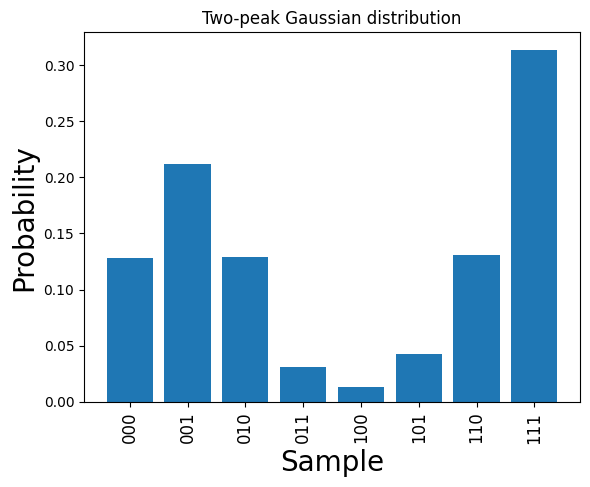

In [5]:
labels = [format(i, "b").zfill(n_qubits) for i in range(len(data))]
plt.bar(range(2**n_qubits), data)
plt.xticks(list(range(len(data))), labels, rotation="vertical", size=12)
plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)
plt.title("Two-peak Gaussian distribution")
plt.show()

## Hyperparameters 

Next, we set the hyperparameters for training the QCBM. To keep it simple, we only consider the following hyperparameters: number of qubits `n_qubits`, number of layers in the QCBM `n_layers`, and the number of iterations in the optimization algorithm.

The number of layers determines how many parameters are in the quantum circuit. For the QCBM, we need `n_params = 3 * n_layers * n_qubits`.

In [6]:
# Declare hyperparameters for QCBM
n_iterations = 5
n_layers = 3

init_params = np.random.rand(3 * n_layers * n_qubits)

qcbm = QCBM(device, n_qubits, n_layers, data)

We use the scipy optimizer "L-BFGS-B" below.

In [7]:
# Training the circuit
from scipy.optimize import minimize

history = []


def callback(x):
    loss = mmd_loss(qcbm.get_probabilities(x), data)
    history.append(loss)


result = minimize(
    lambda x: mmd_loss(qcbm.get_probabilities(x), data),
    x0=init_params,
    method="L-BFGS-B",
    jac=lambda x: qcbm.gradient(x),
    options={"maxiter": n_iterations},
    callback=callback,
)

print(result)

      fun: 0.0034091453255005177
 hess_inv: <27x27 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01892042, -0.00042703, -0.01871226, -0.01175861, -0.01773734,
        0.00017732, -0.00373153, -0.00147817,  0.00159875, -0.00598535,
       -0.00220797, -0.00646174, -0.00127055,  0.00989479, -0.00186534,
        0.00216637, -0.01453949,  0.00337597, -0.00102238, -0.00230746,
        0.00482481, -0.0020789 ,  0.00129113, -0.00062512,  0.00318669,
        0.00397262,  0.00421108])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 6
      nit: 5
     njev: 6
   status: 1
  success: False
        x: array([ 0.45928415,  0.14177025,  0.79213072,  0.66622247,  0.45517018,
        0.83223744,  0.17799168,  0.71590234,  0.15869034,  0.19095004,
        0.14470633,  0.5942404 ,  1.22185465, -0.00962039,  1.28063797,
        0.29197856,  0.73894836,  0.05226552, -0.02050081,  0.62222851,
       -0.18777548,  0.79719876,  0.39829109,  0.25189807,  0.57331064,
       

Below is a plot for the convergence of the loss function.

Text(0.5, 1.0, 'Convergence of the loss function')

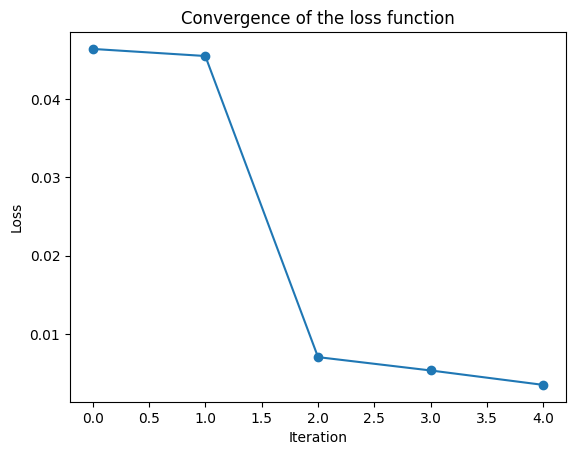

In [8]:
plt.plot(history, "-o")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence of the loss function")

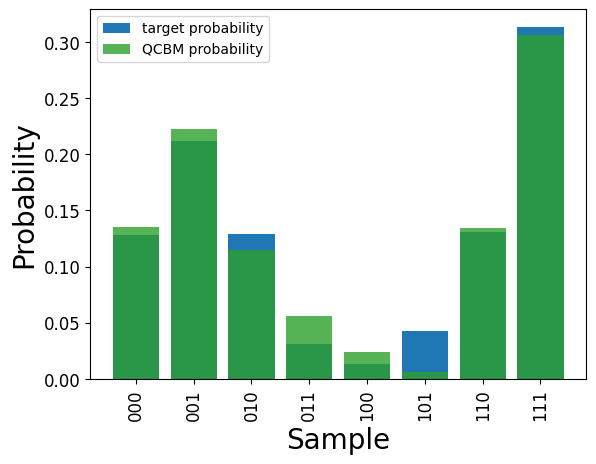

In [9]:
# Plotting the original probability distribution, and the QCBM prediction probability

qcbm_probs = qcbm.get_probabilities(result["x"])

plt.bar(range(2**n_qubits), data, label="target probability", alpha=1, color="tab:blue")
plt.bar(range(2**n_qubits), qcbm_probs, label="QCBM probability", alpha=0.8, color="tab:green")
plt.xticks(list(range(len(data))), labels, rotation="vertical", size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

plt.legend()
plt.show()

Great! As expected, the QCBM probability distribution closes matches the target distribution. 

In [10]:
print("Task Summary")
print(f"{tracker.quantum_tasks_statistics()} \n")
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{} 

Estimated cost to run this example: 0.00 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).